
# Sistema de Recomendación de Películas y Series de Netflix




## Importar librerías

Importamos las librerías necesarias para el procesamiento de datos, visualización y cálculo de similitud.


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



## Cargar el dataset

Leemos el archivo CSV que contiene el catálogo de Netflix.


In [10]:

netflix_dataset=pd.read_csv(r'netflix_dataset.csv')
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...



## Vista de los datos



In [11]:

netflix_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7281 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB



## Información del dataset



In [12]:

dict = {}
for i in list(netflix_dataset.columns):
    dict[i] = netflix_dataset[i].value_counts().shape[0]
    
print(pd.DataFrame(dict,index = ["unique count"]).transpose())


              unique count
show_id               7787
type                     2
title                 7787
director              4049
cast                  6831
country                681
date_added            1565
release_year            73
rating                  14
duration               216
listed_in              492
description           7769



## Verificación de valores nulos

Identificamos cuántos valores faltantes hay en cada columna.


In [13]:

print('Table of missing values: ')
print(netflix_dataset.isnull().sum())


Table of missing values: 
show_id            0
type               0
title              0
director        2389
cast             718
country          506
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


## Análisis de películas vs programas de televisión

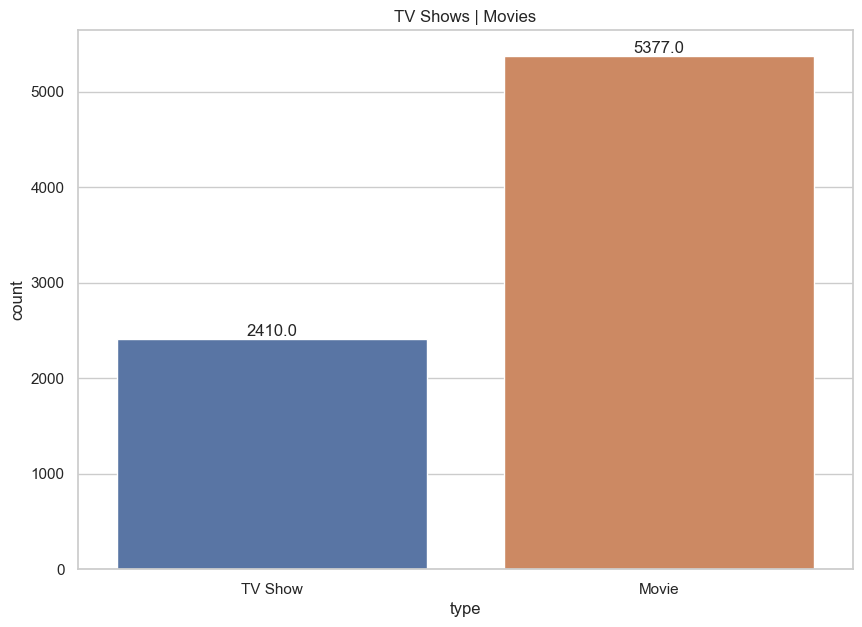

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.set(style='whitegrid')
ax = sns.countplot(x="type", data=netflix_dataset)
ax.set_title("TV Shows | Movies")

# Agregar los totales encima de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=12)

plt.show()

## Mapa de calor para saber en que mes suben mas peliculas

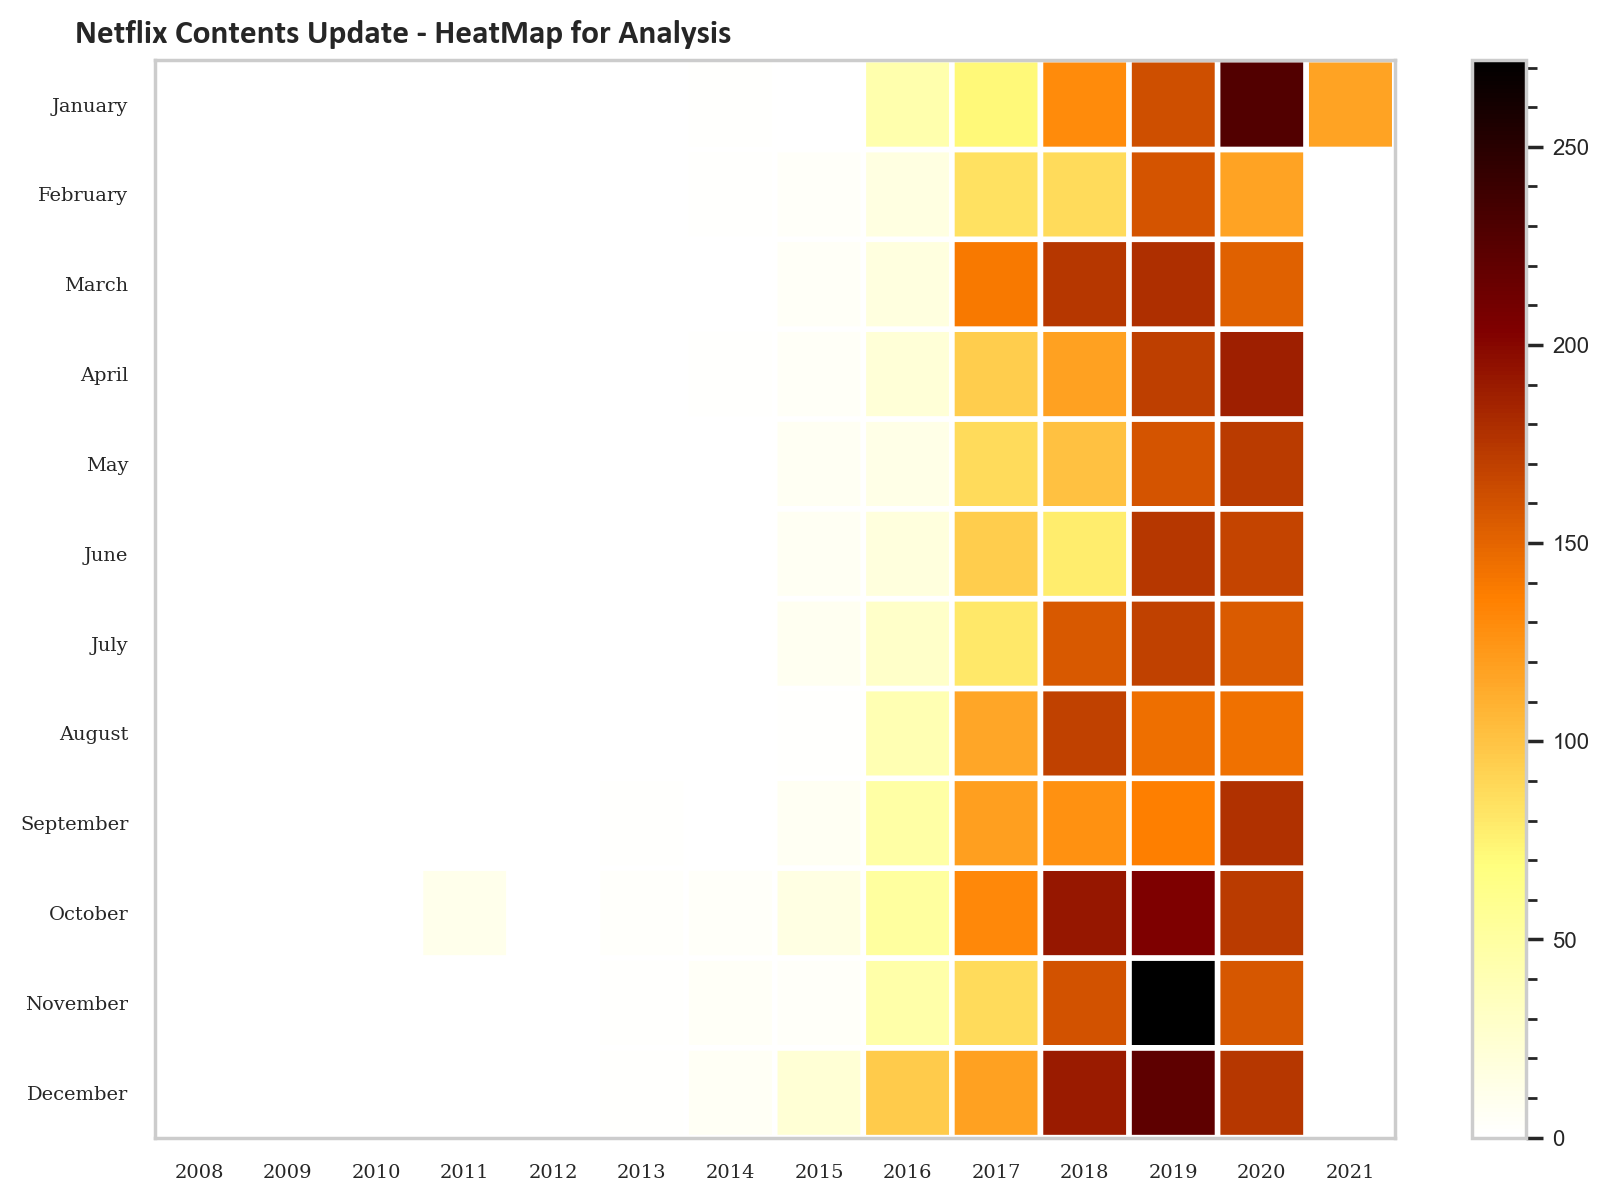

In [15]:
netflix_date = netflix_dataset[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x: x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x: x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December'][::-1]

df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df, cmap='afmhot_r', edgecolors='white', linewidths=2)  # heatmap
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')

plt.title('Netflix Contents Update - HeatMap for Analysis', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0+0.02))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()
plt.show()


## Análisis de calificaciones de películas

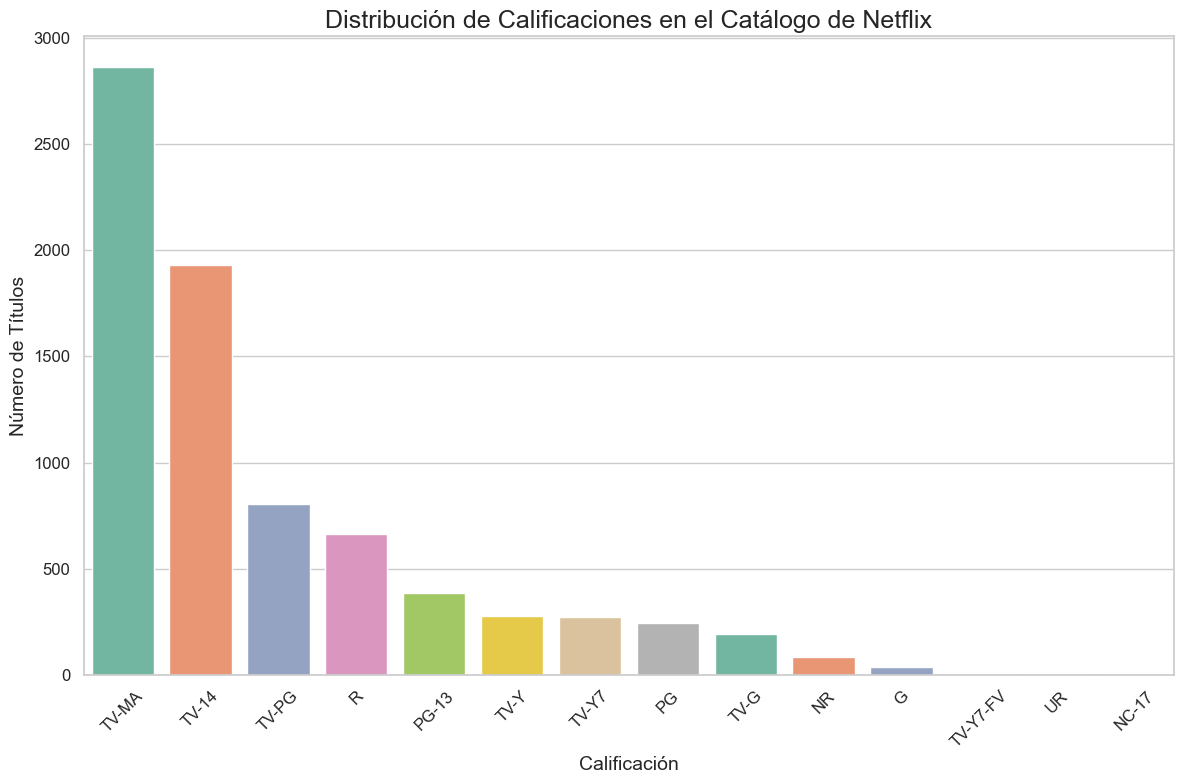

In [16]:
# Análisis de las calificaciones de películas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Más claro y profesional

# Obtener los 15 ratings más frecuentes
top_ratings = netflix_dataset['rating'].value_counts().nlargest(15).index

# Crear gráfico
ax = sns.countplot(
    x="rating",
    data=netflix_dataset,
    palette="Set2",
    order=top_ratings
)

# Títulos y etiquetas
plt.title("Distribución de Calificaciones en el Catálogo de Netflix", fontsize=18)
plt.xlabel("Calificación", fontsize=14)
plt.ylabel("Número de Títulos", fontsize=14)

# Mejorar legibilidad de etiquetas
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar márgenes
plt.tight_layout()
plt.show()


## Análisis de las calificaciones de IMDB para obtener las películas mejor valoradas en Netflix

In [17]:
imdb_ratings=pd.read_csv('IMDb ratings.csv', usecols=['weighted_average_vote'])
imdb_titles=pd.read_csv('IMDb movies.csv', usecols=['title','year','genre'])
ratings = pd.DataFrame({'Title':imdb_titles.title,
                    'Release Year':imdb_titles.year,
                    'Rating': imdb_ratings.weighted_average_vote,
                    'Genre':imdb_titles.genre})
ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)
ratings.shape

C:\Users\tolen\AppData\Local\Temp\ipykernel_12224\1738152228.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles=pd.read_csv('IMDb movies.csv', usecols=['title','year','genre'])


(85852, 4)

## Realizar una unión interna en el conjunto de datos de calificaciones y el conjunto de datos de Netflix para obtener el contenido que tiene ambas calificaciones en IMDB 

In [18]:
ratings.dropna()
joint_data=ratings.merge(netflix_dataset,left_on='Title',right_on='title',how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

## Las 10 películas mejor valoradas en Netflix

In [19]:
import plotly.express as px
top_rated=joint_data[0:10]
fig =px.sunburst(
    top_rated,
    path=['title','country'],
    values='Rating',
    color='Rating')
fig.show()

## Principales países que crean contenidos

In [20]:
country_count=joint_data['country'].value_counts().sort_values(ascending=False)
country_count=pd.DataFrame(country_count)
topcountries=country_count[0:11]
topcountries

,count
country,
United States,799
India,702
United Kingdom,107
Canada,56
Philippines,50
Spain,40
South Korea,36
Indonesia,35
France,33


## Análisis anual

In [21]:
Last_fifteen_years = netflix_dataset[netflix_dataset['release_year']>2005 ]
Last_fifteen_years.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


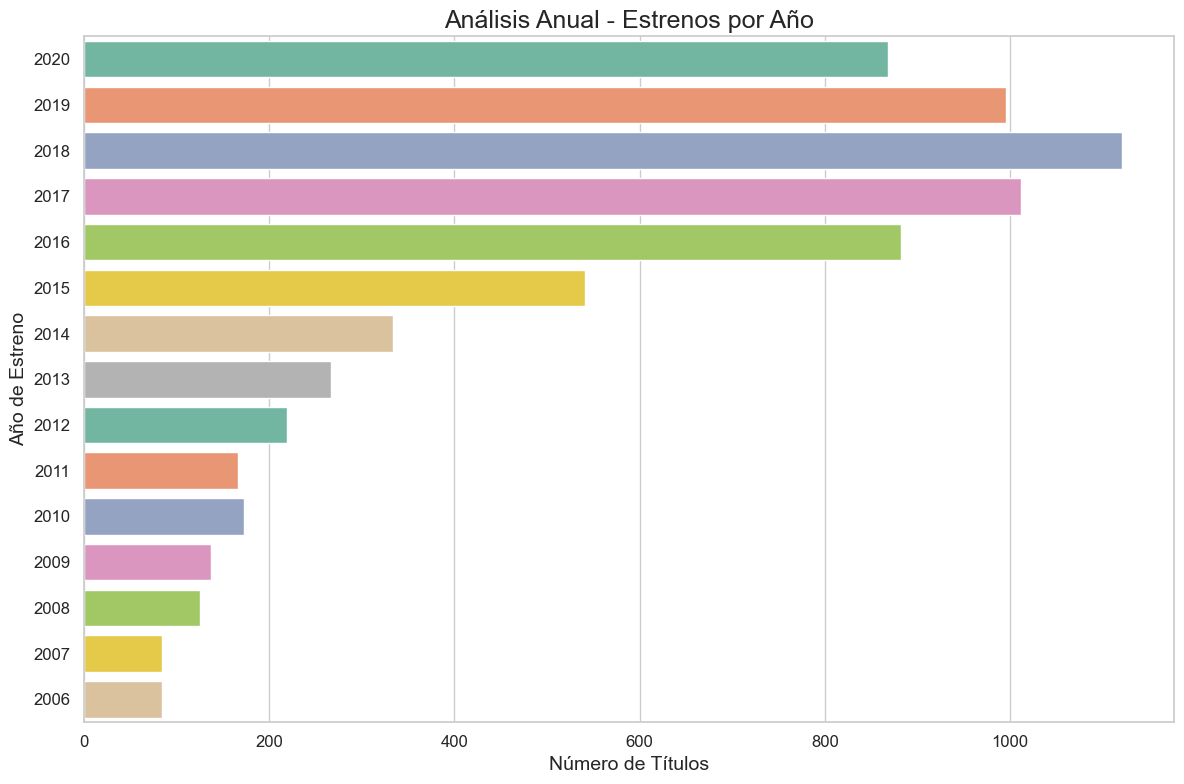

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Ordenar los años en orden descendente para visualización
top_years = netflix_dataset['release_year'].value_counts().index[:15]
top_years_sorted = sorted(top_years, reverse=True)

ax = sns.countplot(
    y="release_year",
    data=Last_fifteen_years,
    palette="Set2",
    order=top_years_sorted
)

plt.title("Análisis Anual - Estrenos por Año", fontsize=18)
plt.xlabel("Número de Títulos", fontsize=14)
plt.ylabel("Año de Estreno", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


## Análisis de programas de televisión en Netflix

In [23]:
# Llenar valores nulos con 'Unknown'
netflix_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].copy()

netflix_shows['country'] = netflix_shows['country'].fillna('Unknown')

# Crear el diccionario de conteo
countries = {}

# Obtener la lista de valores
country_list = list(netflix_shows['country'])

# Recorrer cada entrada
for entry in country_list:
    # Dividir por comas y quitar espacios
    split_countries = [c.strip() for c in entry.split(',')]
    
    # Contar cada país
    for country in split_countries:
        if country in countries:
            countries[country] += 1
        else:
            countries[country] = 1

# Revisar resultado
countries


{'Brazil': 29,
 'Turkey': 28,
 'Poland': 8,
 'United States': 866,
 'Mexico': 53,
 'Unknown': 276,
 'Japan': 184,
 'South Korea': 157,
 'United Kingdom': 256,
 'India': 75,
 'Canada': 126,
 'Italy': 23,
 'Spain': 57,
 'Australia': 60,
 'Taiwan': 70,
 'China': 45,
 'Germany': 42,
 'France': 84,
 'Singapore': 22,
 'Russia': 17,
 'Mauritius': 1,
 'South Africa': 10,
 'Lebanon': 7,
 'Colombia': 28,
 'Argentina': 18,
 'Philippines': 1,
 'Finland': 4,
 'Netherlands': 8,
 'Chile': 5,
 'Thailand': 22,
 'Nigeria': 8,
 'Saudi Arabia': 4,
 'Syria': 1,
 'Egypt': 13,
 'Kuwait': 3,
 'Belgium': 11,
 'Norway': 9,
 'Sweden': 10,
 'Denmark': 13,
 'Israel': 8,
 'Ireland': 12,
 'Iceland': 2,
 'Indonesia': 3,
 'Malaysia': 8,
 'New Zealand': 8,
 'Czech Republic': 6,
 'Cuba': 1,
 'Austria': 1,
 'Greece': 2,
 'Hong Kong': 5,
 'Pakistan': 4,
 'Luxembourg': 1,
 'Jordan': 1,
 'Uruguay': 1,
 'Azerbaijan': 1,
 'West Germany': 2,
 'Puerto Rico': 1,
 'Malta': 1,
 'Senegal': 1,
 'Ukraine': 2,
 'Switzerland': 1,
 'Bel

In [24]:
countries_fin={}
for country,no in countries.items():
    country=country.replace(' ','')
    if country in list(countries_fin.keys()):
        countries_fin[country]+=no
    else:
        countries_fin[country]=no
        
countries_fin={k: v for k, v in sorted(countries_fin.items(), key=lambda item: item[1], reverse= True)}

[Text(0, 0, 'UnitedStates'),
 Text(1, 0, 'Unknown'),
 Text(2, 0, 'UnitedKingdom'),
 Text(3, 0, 'Japan'),
 Text(4, 0, 'SouthKorea'),
 Text(5, 0, 'Canada'),
 Text(6, 0, 'France'),
 Text(7, 0, 'India'),
 Text(8, 0, 'Taiwan'),
 Text(9, 0, 'Australia')]

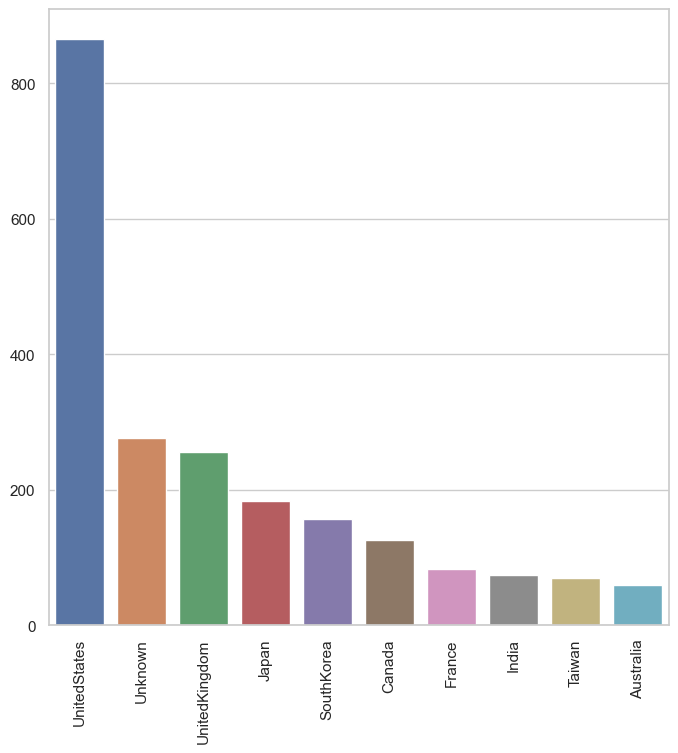

In [25]:

plt.figure(figsize=(8,8))
ax = sns.barplot(x=list(countries_fin.keys())[0:10],y=list(countries_fin.values())[0:10])
ax.set_xticklabels(list(countries_fin.keys())[0:10],rotation = 90)

## Análisis de la duración de las películas

In [26]:
netflix_movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].copy()

netflix_movies['duration']=netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration']=netflix_movies['duration'].astype(str).astype(int)
netflix_movies['duration']

1        93
2        78
3        80
4       123
6        95
       ... 
7781     88
7782     99
7783    111
7784     44
7786     90
Name: duration, Length: 5377, dtype: int32

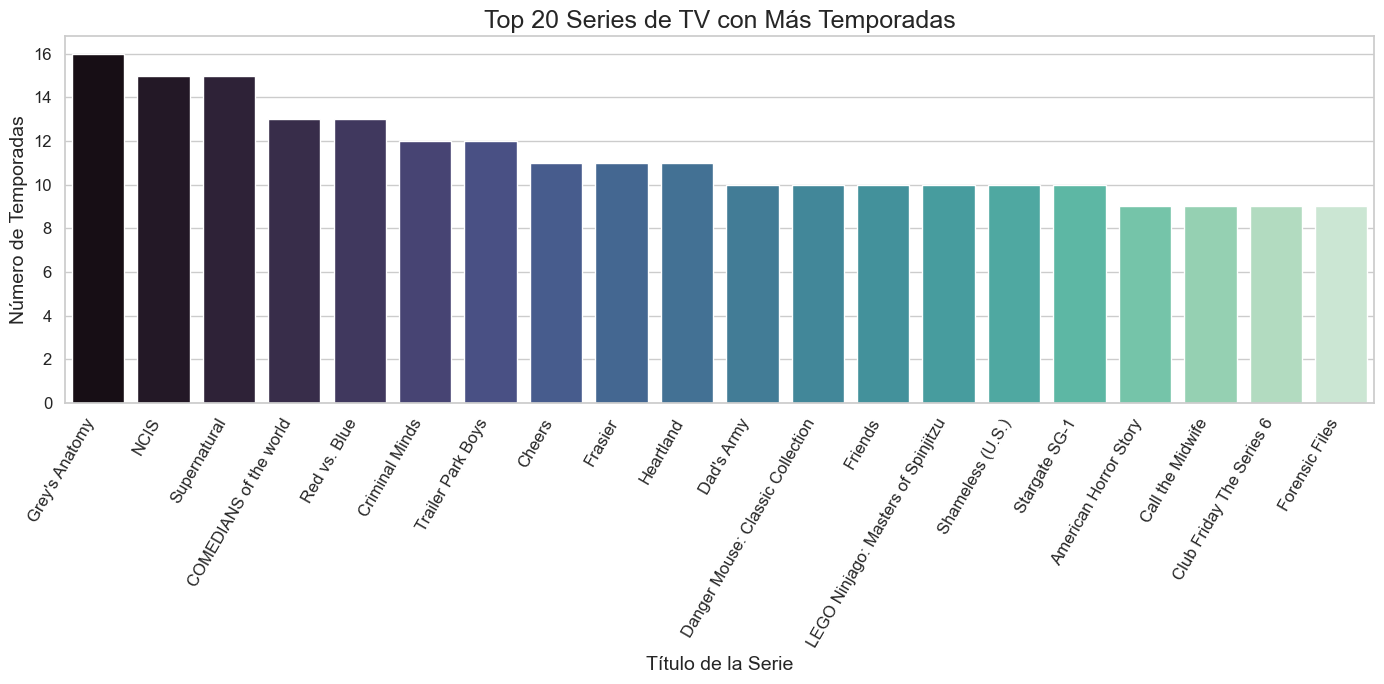

In [27]:
# Filtrar solo Series de TV
netflix_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].copy()

# Limpiar la columna 'duration' para extraer el número de temporadas
netflix_shows['duration'] = netflix_shows['duration'].str.replace(' Seasons', '', regex=False)
netflix_shows['duration'] = netflix_shows['duration'].str.replace(' Season', '', regex=False)

# Manejar valores faltantes o extraños
netflix_shows['duration'] = netflix_shows['duration'].fillna('0')
netflix_shows['duration'] = netflix_shows['duration'].astype(int)

# Top 20 series con más temporadas
top20_seasons = netflix_shows.nlargest(20, 'duration')

# Graficar
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

ax = sns.barplot(
    x='title',
    y='duration',
    data=top20_seasons,
    palette='mako'  # Puedes probar con 'crest', 'rocket', 'pastel', etc.
)

# Estética
plt.title('Top 20 Series de TV con Más Temporadas', fontsize=18)
plt.xlabel('Título de la Serie', fontsize=14)
plt.ylabel('Número de Temporadas', fontsize=14)
plt.xticks(rotation=60, fontsize=12, ha='right')
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


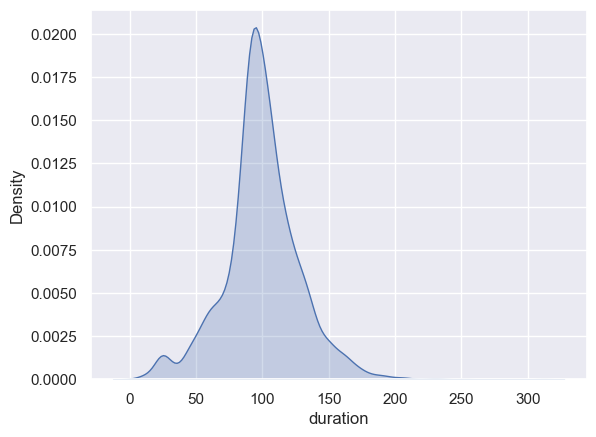

In [28]:
sns.set(style="darkgrid")
ax = sns.kdeplot(data=netflix_movies['duration'], fill=True)

## Análisis de la duración de los programas de televisión

<Axes: xlabel='title'>

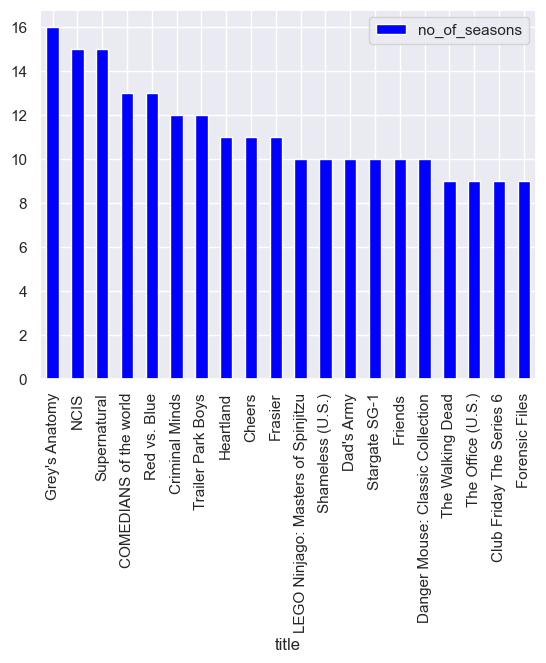

In [29]:
features = ['title', 'duration']
durations = netflix_shows[features].copy()

# Si duration ya es entero, solo asigna:
durations['no_of_seasons'] = durations['duration']

# Si quieres asegurarte que no hay nulos:
durations['no_of_seasons'] = durations['no_of_seasons'].fillna(0).astype(int)

# Ahora puedes seguir con el análisis o visualización
t = ['title', 'no_of_seasons']
top = durations[t].sort_values(by='no_of_seasons', ascending=False)
top20 = top.head(20)
top20.plot(kind='bar', x='title', y='no_of_seasons', color='blue')

In [30]:
durations['no_of_seasons']=durations['no_of_seasons'].astype(str).astype(int)

In [31]:
t=['title','no_of_seasons']
top=durations[t]

top=top.sort_values(by='no_of_seasons', ascending=False)

<Axes: xlabel='title'>

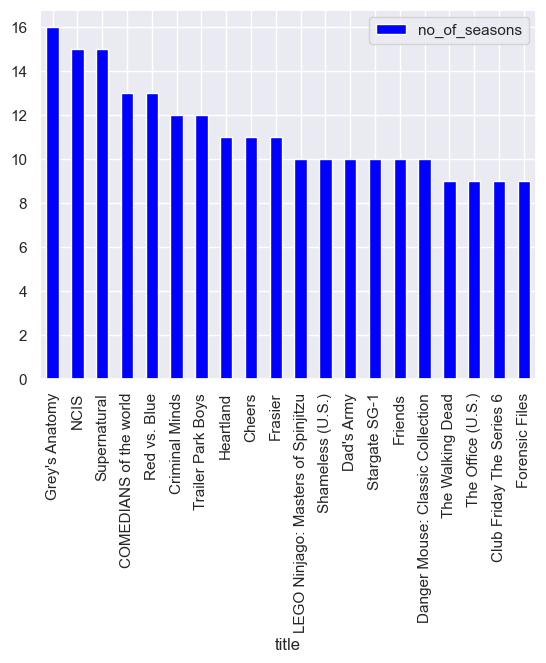

In [32]:
top20=top[0:20]
top20.plot(kind='bar',x='title',y='no_of_seasons', color='blue')

## Sistema de recomendación basado en contenido

In [33]:
#Recomendador basado en descripción de la trama (Recomendaciones basadas en contenido)

netflix_dataset['description'].head()

0    In a future where the elite inhabit an island ...
1    After a devastating earthquake hits Mexico Cit...
2    When an army recruit is found dead, his fellow...
3    In a postapocalyptic world, rag-doll robots hi...
4    A brilliant group of students become card-coun...
Name: description, dtype: object

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear la matriz TF-IDF usando la columna 'description'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'].fillna(''))

Vamos a definir una función que toma el título de una película como entrada y genera una lista de las 10 películas más similares.

In [35]:
#Construir un mapa inverso de índices y títulos de películas
indices = pd.Series(netflix_dataset.index, index=netflix_dataset['title']).drop_duplicates()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Crear la matriz TF-IDF usando la columna 'description'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'].fillna(''))

# Calcular la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Construir un mapa inverso de índices y títulos de películas
indices = pd.Series(netflix_dataset.index, index=netflix_dataset['title']).drop_duplicates()

# Función que toma el título de la película como entrada y genera la mayoría de las películas similares
def get_recommendations(title, cosine_sim=cosine_sim):
    # Obtener el índice de la película que coincide con el título
    idx = indices[title]

    # Obtenga las puntuaciones de similitud de pares de todas las películas con esa película
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordena las películas según los puntajes de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtén las puntuaciones de las 10 películas más similares
    sim_scores = sim_scores[1:11]

    # Obtener los índices de la película
    movie_indices = [i[0] for i in sim_scores]

    # Devuelve el top 10 de películas más similares
    return netflix_dataset['title'].iloc[movie_indices]

In [37]:
get_recommendations('Welcome')

1761                  Dil Vil Pyaar Vyaar
6782                The Princess Weiyoung
866                               Bewafaa
3082                     It's Okay, Buddy
7245                           True Tunes
2472                             Gomorrah
302                      Acts of Violence
3859                          Magnificent
4938    Power Rangers Operation Overdrive
4692                        Our Godfather
Name: title, dtype: object

In [38]:
get_recommendations('Avengers: Infinity War')

6920                              The Talented Mr. Ripley
6270                                         The Darkness
400                                Aliens Ate My Homework
3589              LEGO Marvel Super Heroes: Black Panther
1338                       Chilling Adventures of Sabrina
7446                                              Vroomiz
4678                                            Orbiter 9
1448                                           Code Lyoko
7388                                             Vampires
3590    LEGO Marvel Super Heroes: Guardians of the Galaxy
Name: title, dtype: object

In [39]:
get_recommendations('LEGO Marvel Super Heroes: Black Panther')

5439                       Scorpion King 5: Book of Souls
635                                Avengers: Infinity War
4927                         Power Rangers Beast Morphers
2038                            EVANGELION: DEATH (TRUE)²
2438                                        Glitter Force
6906                  The Story of Us with Morgan Freeman
3590    LEGO Marvel Super Heroes: Guardians of the Galaxy
1825                                   Doom: Annihilation
3668                  Little Singham aur Kaal ka Mahajaal
959                                         Black Panther
Name: title, dtype: object

In [40]:
#Rellenar valores nulos con una cadena vacía.
filledna=netflix_dataset.fillna('')
filledna.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


El siguiente paso sería convertir los nombres y las instancias de palabras clave a minúsculas y eliminar todos los espacios entre ellos

In [41]:
#Limpieza de datos: convertir todas las palabras en minúsculas
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [42]:
#Identificar las características sobre las que se filtrará el modelo.
features=['title','director','cast','listed_in','description']
filledna=filledna[features]

In [43]:
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
filledna.head()

,title,director,cast,listed_in,description
0,3%,,"joãomiguel,biancacomparato,michelgomes,rodolfo...","internationaltvshows,tvdramas,tvsci-fi&fantasy",inafuturewheretheeliteinhabitanislandparadisef...
1,07:19,jorgemichelgrau,"demiánbichir,héctorbonilla,oscarserrano,azalia...","dramas,internationalmovies","afteradevastatingearthquakehitsmexicocity,trap..."
2,23:59,gilbertchan,"teddchan,stellachung,henleyhii,lawrencekoh,tom...","horrormovies,internationalmovies","whenanarmyrecruitisfounddead,hisfellowsoldiers..."
3,9,shaneacker,"elijahwood,johnc.reilly,jenniferconnelly,chris...","action&adventure,independentmovies,sci-fi&fantasy","inapostapocalypticworld,rag-dollrobotshideinfe..."
4,21,robertluketic,"jimsturgess,kevinspacey,katebosworth,aaronyoo,...",dramas,abrilliantgroupofstudentsbecomecard-countingex...


 actores, director y palabras clave

In [44]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

filledna['soup'] = filledna.apply(create_soup, axis=1)

Los siguientes pasos son los mismos que los que utilizamos con nuestro recomendador basado en la descripción de la trama.


In [45]:
# Importa CountVectorizer y crea la matriz de conteo
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])

In [46]:
# Calcule la matriz de similitud de coseno basándose en count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [47]:
# Restablecer el índice de nuestro DataFrame principal y construir un mapeo inverso como antes
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])

In [48]:
import numpy as np

def recommend_similar_titles(query, sim_matrix=cosine_sim):
    # limpiamos y normalizamos el título de búsqueda
    key = query.strip().lower().replace(" ", "")
    idx = indices[key]

    # cogemos el vector de similitud para ese índice
    scores = sim_matrix[idx]

    # ordenamos los índices por puntuación descendente
    ordered_idxs = np.argsort(scores)[::-1]

    # quitamos el propio título y nos quedamos con los 10 primeros
    top10 = [i for i in ordered_idxs if i != idx][:10]

    # devolvemos los títulos correspondientes
    return netflix_dataset.loc[top10, "title"]


In [49]:
recommend_similar_titles('Welcome', cosine_sim2)


6016            Tees Maar Khan
6863             The Shaukeens
1740        Dhoondte Reh Jaoge
3215                     Joker
2862    Humko Deewana Kar Gaye
354                    Aitraaz
6042                 Thank You
4846           Phir Hera Pheri
5052                      Race
3874     Maine Pyaar Kyun Kiya
Name: title, dtype: object

In [50]:
recommend_similar_titles('Avengers: Infinity War', cosine_sim2)


7058                               Thor: Ragnarok
5698                      Solo: A Star Wars Story
2700                                          Her
5118                                   Real Steel
5699    Solo: A Star Wars Story (Spanish Version)
959                                 Black Panther
3006                                     Inkheart
5632                                  Singularity
6889                         The Space Between Us
2586                      Halo: The Fall of Reach
Name: title, dtype: object

In [51]:
recommend_similar_titles('Dil Dhadakne Do', cosine_sim2)

7769    Zindagi Na Milegi Dobara
362                     AK vs AK
6878             The Sky Is Pink
1757              Dil Chahta Hai
3912                        Mann
4872                          PK
2571                      Haapus
5954            Taare Zameen Par
886               Bhangra Paa Le
1261             Chal Dhar Pakad
Name: title, dtype: object

In [52]:
# a) ¿Cuántas series tiene el data set?
num_series = netflix_dataset[netflix_dataset['type'] == 'TV Show'].shape[0]
print(f"Series: {num_series}")  # Esperado: 2410

# b) ¿Cuántas películas tiene el data set?
num_movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].shape[0]
print(f"Películas: {num_movies}")  # Esperado: 5377

# c) ¿Cuántos títulos tiene el data set?
num_titles = netflix_dataset['title'].nunique()
print(f"Títulos únicos: {num_titles}")  # Esperado: 7783

# d) ¿Cuáles son los atributos llave del data set?
columns = list(netflix_dataset.columns)
print(f"Atributos clave: {columns}")  # Esperado: show_id y title

Series: 2410
Películas: 5377
Títulos únicos: 7787
Atributos clave: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [1]:
import pandas as pd
import os

# Leer ambos datasets si existen
files = []
if os.path.exists('netflix_dataset.csv'):
    files.append(pd.read_csv('netflix_dataset.csv'))
if os.path.exists('netflix_dataset_2025.csv'):
    files.append(pd.read_csv('netflix_dataset_2025.csv'))

if not files:
    raise FileNotFoundError("No se encontró ningún archivo de dataset de Netflix.")

# Unir y eliminar duplicados por 'show_id' o 'title'
netflix_full = pd.concat(files, ignore_index=True)
if 'show_id' in netflix_full.columns:
    netflix_full = netflix_full.drop_duplicates(subset=['show_id'])
else:
    netflix_full = netflix_full.drop_duplicates(subset=['title'])

# Guardar el dataset combinado
netflix_full.to_csv('netflix_full_2025.csv', index=False)
print("Archivo combinado guardado como netflix_full_2025.csv")

Archivo combinado guardado como netflix_full_2025.csv


In [2]:
import numpy as np

netflix_dataset = pd.read_csv('netflix_full_2025.csv')
netflix_dataset['description'] = netflix_dataset['description'].replace('', np.nan)
netflix_dataset = netflix_dataset.dropna(subset=['description']).reset_index(drop=True)

# Eliminar duplicados por título por seguridad
netflix_dataset = netflix_dataset.drop_duplicates(subset='title').reset_index(drop=True)

print("Dimensiones después de limpiar:", netflix_dataset.shape)


Dimensiones después de limpiar: (32278, 19)


C:\Users\tolen\AppData\Local\Temp\ipykernel_8544\4084788055.py:3: DtypeWarning: Columns (0,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  netflix_dataset = pd.read_csv('netflix_full_2025.csv')


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'])
n_docs = tfidf_matrix.shape[0]

chunk_size = 1000  # Ajusta según tu RAM
cosine_sim_path = 'cosine_sim_full_2025.dat'
cosine_sim = np.memmap(
    cosine_sim_path,
    dtype='float32',
    mode='w+',
    shape=(n_docs, n_docs)
)

for start in range(0, n_docs, chunk_size):
    end = min(start + chunk_size, n_docs)
    sims_chunk = linear_kernel(tfidf_matrix[start:end], tfidf_matrix)
    cosine_sim[start:end, :] = sims_chunk
    print(f"Procesado bloque {start}–{end}")

cosine_sim.flush()
del cosine_sim

Procesado bloque 0–1000
Procesado bloque 1000–2000
Procesado bloque 2000–3000
Procesado bloque 3000–4000
Procesado bloque 4000–5000
Procesado bloque 5000–6000
Procesado bloque 6000–7000
Procesado bloque 7000–8000
Procesado bloque 8000–9000
Procesado bloque 9000–10000
Procesado bloque 10000–11000
Procesado bloque 11000–12000
Procesado bloque 12000–13000
Procesado bloque 13000–14000
Procesado bloque 14000–15000
Procesado bloque 15000–16000
Procesado bloque 16000–17000
Procesado bloque 17000–18000
Procesado bloque 18000–19000
Procesado bloque 19000–20000
Procesado bloque 20000–21000
Procesado bloque 21000–22000
Procesado bloque 22000–23000
Procesado bloque 23000–24000
Procesado bloque 24000–25000
Procesado bloque 25000–26000
Procesado bloque 26000–27000
Procesado bloque 27000–28000
Procesado bloque 28000–29000
Procesado bloque 29000–30000
Procesado bloque 30000–31000
Procesado bloque 31000–32000
Procesado bloque 32000–32278


In [4]:
# Cargar matriz memmap para lectura
cosine_sim = np.memmap(
    'cosine_sim_full_2025.dat',
    dtype='float32',
    mode='r',
    shape=(len(netflix_dataset), len(netflix_dataset))
)

# Crear índice de títulos a posición
indices = pd.Series(netflix_dataset.index, index=netflix_dataset['title'])


In [5]:
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        print(f"'{title}' no está en el dataset.")
        return []

    idx = indices[title]

    # Asegurar que sea un solo índice
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i for i, _ in sim_scores]
    return list(netflix_dataset['title'].iloc[movie_indices])


In [6]:
print(get_recommendations('El espinazo del diablo'))
print(get_recommendations('13 fantasmas'))
print(get_recommendations('Locke & Key'))


'El espinazo del diablo' no está en el dataset.
[]
'13 fantasmas' no está en el dataset.
[]
['The Game of Keys', 'Wish Upon', 'Locked In', 'The Umbrella Academy', 'The Key Game', 'The Pyramid', 'Children Ruin Everything', 'The Lodgers', 'Family United', 'The Loud House Movie']
